# PasswordCard experiments
Taking https://www.passwordcard.org/en to new places — 3/21/22 - joeldg

The idea here is to take PasswordCard and apply easier lookup symbols and make nice some updates.

| original | updated |
| --- | --- |
| ![Orig](SS1.png) | ![Orig](SS2.png) |

The original PasswordCard is great but in most cases people are going to use familiar symbols like the umbrella, star, musical notes and the dollar sign. Picking familiar icon headers is a security problem and the ascii headers don't lend themselves to memonic memorization. Also, the code to generate the card seed in the original is required to be a hexadecimal number, I have changed it to use a phrase or password and still be deterministic so the card can be re-generated without having to deal with typing in that code.

Instead of "yellow interrobang" or "green square" we can swap out to "purple gorilla" or, with a possible addition of left side icons, you could change it to "green island butterfly" or "Blue compass shark"
Colors are also less important in this instance and so you can print on black and white printers and be color-blind friendly. 

To help sort issues raised with projects like [Munchkin](https://github.com/gszathmari/munchkin) I have added a few things:

- One major *optional* improvement I want to add is transparent veritical bars periodically through the card, these can be used to easily count characters if you have a standard eight or 12 character passwords or as 'bounce-off' bars. I.e. second vertical bar you cross, change direction, and so on. These can be modified in the code below.

- I additionally added *optional* psuedo-randomized 'key' blocks which can be used to modify the pattern you develop for your card. It works by adding a thick box around one random letter per (every other) column and if encountered can be used to modify the password pattern. Here are some ideas.
    - Change direction first up, or reverse, etc.
    - Jump to the next lower or upper line.
    - Jump to the next key-block found to the right (or left) or up (or down)
    - Rotation cypher, A becomes B, C becomes D and so on.
    - Jump to the next keyblock in alpha order
    - Circle around the keyblock

To use: come up with a card method and remember that, here are a couple 'method' ideas.
   - "animals stomp boxes", use 'animals' font and when you encounter a box don't use the character in the box, 'circle' around it. Go below in top half of the card and above in bottom half.
   - "teleport around outside", use the 'outside' icons and when you encounter a column bar, teleport to the next bar to the right and continue, if you hit the far right bar, continue from the left.
    
The idea is to come up with something memorable (first) and usable (second) while keeping the passwords to a fixed length or 8 or 12. Combined with U2F (Yubikey) and/or 2FA (phone) these kinds of methods are safe—even if someone were to get your card, they don't know your method and won't have your other keys/codes.

Really, the main idea is to make these fun and easy to use ... and with this Jupyter book, you can go plug in your own icon/digbat font--maybe avoid using web icon fonts that include logos unless your card method is solid.

This is obviously opensource and you can do whatever with this.

Clone the notebook and enjoy :)


In [550]:
import numpy as np
import random

CHARSETS = {
    'original.digits': u"0123456789",
    'original.alphanumeric': u"23456789abcdefghjkmnpqrstuvwxyzABCDEFGHJKLMNPQRSTUVWXYZ",
    'original.alphanumeric_with_symbols': u"23456789abcdefghjkmnpqrstuvwxyzABCDEFGHJKLMNPQRSTUVWXYZ@#$%&*<>?+{}[]()/\\"
    }

HEADERS = {
    'original': u"■□▲△○●★☂☀☁☹☺♠♣♥♦♫€¥£$!?¡¿⊙◐◩�", # standard unicode
    'animals' : u"%)hKNgH$?<+_89UVW4!@v1ABOoz*p", # from wildlife font.
    'outdoors': u"rs{nfgE$3<+_m9UqW4!@!1ABRoz*p",
    'heydings': u"rsKnfgE$3L+hmWUqG48@2HOMRol*p",
    'webdings': u"rs!%fNz$7LdhmWUqG48@2HOl,olJp",
    }

HEADERS_FONTS = {
    'original': "DejaVuSans.ttf", # required for unicode
    'animals' : "wildlife.otf", 
    'outdoors': "dnr.ttf",
    'heydings': "heydings_icons.ttf",
    'webdings': "modernpics.otf",
}

SIDE_ICONS = {
    'heydings': u"GhKq8Hfs",
    'outdoors': u"zfgmrstW",
    'animals' : u")KA7Q_?w",
    'numbers' : u"12345678",
    'letters' : u"ABCDEFGH",
}

SIDE_FONTS = {
    'heydings': "heydings_icons.ttf",
    'outdoors': "dnr.ttf",
    'animals' : "wildlife.otf",
    'numbers' : "Andale Mono",
    'letters' : "Andale Mono",
    'webdings': "modernpics.otf",
}

THEMES = {
    'original': [(255,255,255),(192,192,192),(255,192,192),(192,255,192),(255,255,192),(192,192,255),(255,192,255),(192,255,255)],
    'default' : [(240,248,255),(127,255,212),(255,127,80),(162,205,90),(191,62,255),(238,201,0),(173,173,173),(255,182,193)]
}

#theme = [[240,248,255],[127,255,212],[255,127,80],[162,205,90],[191,62,255],[238,201,0],[173,173,173],[255,182,193]]
theme = [(240,248,255),(127,255,212),(255,127,80),(162,205,90),(191,62,255),(238,201,0),(173,173,173),(255,182,193)]


def generate_my_seed(seedPhrase):
    mybytes = seedPhrase.encode('utf-8')
    return int.from_bytes(mybytes, 'little')

def generate_character_sets(symbols="", digits=""):
    characters = {}
    characters['top_odd'] = list(CHARSETS['original.alphanumeric'])
    characters['top_even'] = list(CHARSETS['original.alphanumeric_with_symbols'])
    characters['bottom_odd'] = list(CHARSETS['original.alphanumeric'])
    characters['bottom_even'] = list(CHARSETS['original.alphanumeric_with_symbols'])
    return characters

def generate_card(seed, headers='original', width=29, height=8, symbols=False, digits=False):
    characters = generate_character_sets(symbols, digits)
    myint = generate_my_seed(seed)
    
    #print(f"My starting seed: {myint}\n")
    
    header = list(HEADERS[headers])
    random.Random(myint).shuffle(header)
        
    contents = []

    midheight = 1 + round(height/2)

    for i in range(1, midheight):
        line = []
        for j in range(width):
            myint = myint + 1
            # Even columns
            if j % 2 == 0:
                line.append(characters['top_even'][random.Random(myint).randrange(len(characters['top_even']))])
            # Odd columns
            else:
                line.append(characters['top_odd'][random.Random(myint).randrange(len(characters['top_odd']))])
        contents.append(u''.join(line))
    for j in range(midheight, height+1):
        line = []
        for j in range(width):
            myint = myint + 1
            # Even columns
            if j % 2 == 0:
                line.append(characters['bottom_even'][random.Random(myint).randrange(len(characters['bottom_even']))])
            # Odd columns
            else:
                line.append(characters['bottom_odd'][random.Random(myint).randrange(len(characters['bottom_odd']))])
        contents.append(u''.join(line))

    return u''.join(header), contents

"""
do seed and generate the card and look at it.
"""
seedPhrase="My Random Seed2"
data = generate_card(seedPhrase, "heydings")
random.Random(generate_my_seed(seedPhrase)).shuffle(theme)
side_icons_list = list(SIDE_ICONS['outdoors'])
random.Random(generate_my_seed(seedPhrase)).shuffle(side_icons_list)
side_icons = ''.join(side_icons_list)

print(theme)
print(data[0])
for v in data[1]:
    print(v)


[(255, 182, 193), (173, 173, 173), (127, 255, 212), (255, 127, 80), (162, 205, 90), (238, 201, 0), (191, 62, 255), (240, 248, 255)]
KHfWpE*gU2L$h4Rln+s@qo38MmOGr
+gRNua\eH9rz*gdCjW%a]AmvCRDEK
myN2%eYrCtks6fkAdgLe<Zrk/Cw9y
WHkNhMLczY?k%XFY7K(hQ2#D]UtR+
wud5}W(z&C&frg[tTftJ3h#mPR&SY
DeD834JKaWjKdx?MYZ4CbpDE>Zpt+
+bmbcUTz>HdUbY9qdk(CquCc\m+3(
UWMg+hACrNqD&RdZhD<QDupA*F@LL
]aqRyQ>CRr>j4Fkjkacajb\EpHtE?


## okay, we can produce the data for the card, and we can recreate it every time
## with the same seed.  Let's try to generate a card image with some fonts..
## this is a test, so continue on to see the function.

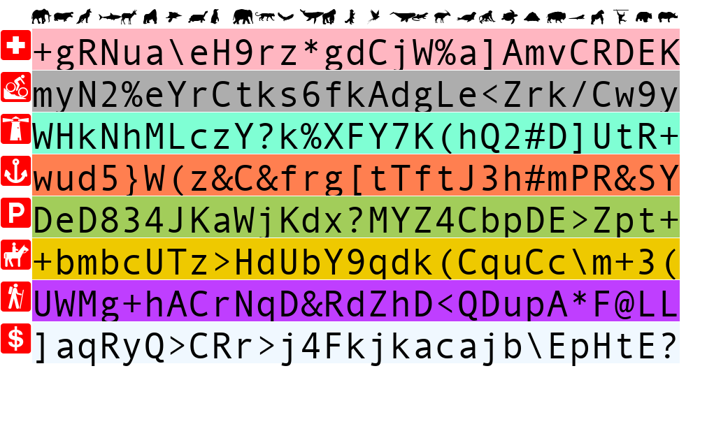

In [551]:
"""
QUICK TEST OF THE ABOVE AND FOR FONT SPACING
"""
from PIL import Image, ImageFont, ImageDraw

header_font_file = 'wildlife.otf'# 'wildlife.otf', 'heydings_icons.ttf', 'dnr.ttf'
side_font_file = 'dnr.ttf'

#basefont = ImageFont.load_default()
# mono base fonts: "Andale Mono", "Courier", "Menlo"
basefont = ImageFont.truetype("Andale Mono", 53)

image = Image.new(mode='RGB', size=(1011, 637), color='#ffffff')
draw = ImageDraw.Draw(im=image)

base_rect_offset = 40
base_rect_depth = base_rect_offset + 60

"""
Draw the colored rectangles and fill with data
"""
side_font=ImageFont.truetype(font=side_font_file, size=54) # same size as base
offset = 0
#draw.rectangle((1, base_rect_offset, 44, base_rect_offset+(60*8)), fill=('black'), outline=('white'))
for idx, val in enumerate(theme, start=1):
    bbox = draw.textbbox((1, base_rect_offset+offset+2), side_icons[idx-1], font=header_font)
    draw.text(xy=(1, base_rect_offset+offset+2), text=side_icons[idx-1], font=side_font, fill='red')
    
    draw.rectangle((45, base_rect_offset+offset, 972, base_rect_depth+offset), fill=(val), outline=(255, 255, 255))
    draw.text(xy=(45, 44+offset), text=data[1][idx-1], font=basefont, fill='black')
    offset = (60*idx)
   
"""
Draw the headers
"""
text_text_width=972-45
max_font_width=int(text_text_width/len(data[0])+1)
header_font=ImageFont.truetype(font=header_font_file, size=max_font_width)
xy = (45, 5)
max_len = max(font.getsize(c) for c in data[0])
x, y = xy
for c in data[0]:
  bbox = draw.textbbox((x, y), c, font=header_font)
  #draw.rectangle(bbox, fill='white', outline="red")
  draw.text(xy=(x, 5), text=c, font=header_font, fill='black')
  x += max_font_width
  
scale = 0.7
display(image.resize(( int(image.width * scale), int(image.height * scale))))

# here is our test

## So now we have everything in place and can create a function.
## and set it up with proper inputs so we can control everything with one call.
The outline will look like:
* manage inputs
* generate and manage header, side and lines
* determine fonts and which sets to use for headers/side
* generate and return image

### so now we are going to add a couple things which will add security.
* Vertical bars which add in ease of use for visually getting to a password

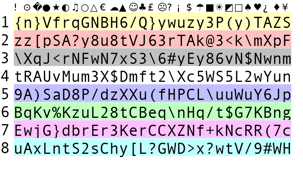

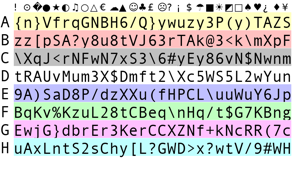

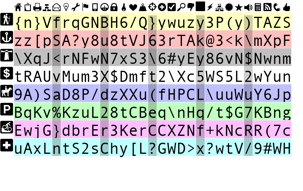

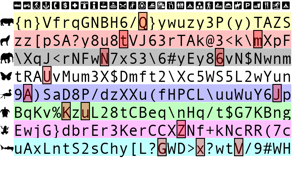

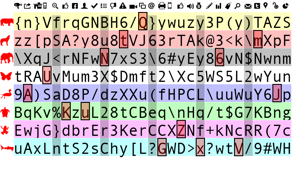

In [559]:
from PIL import Image, ImageFont, ImageDraw

"""
Generate our new type of PasswordCard.
"""
def passwordcard(
        seed, 
        headers   = 'original', 
        siders    = 'numbers',
        rnd_head  = True,
        rnd_side  = False, 
        vert_bars = False,
        key_boxes = False,    
        theme     = 'original',
        hcolor    = 'black',
        scolor    = 'black'
    ):
    data  = generate_card(seed, headers)
    
    header_font     = HEADERS_FONTS[headers]
    side_font       = SIDE_FONTS[siders]
    side_icons_list = list(SIDE_ICONS[siders])
    myint = generate_my_seed(seed)
    if rnd_side:
        random.Random(myint).shuffle(side_icons_list)
        
    theme = list(THEMES[theme])
    random.Random(myint).shuffle(theme)
    side_icons = ''.join(side_icons_list)
        
    # we should have everything needed for the basic card now.    
    basefont         = ImageFont.truetype("Andale Mono", 53) # "Andale Mono", "Courier" (54), "Menlo"
    sidefont         = ImageFont.truetype(side_font, 53)
    headerfont       = ImageFont.truetype(header_font, 53)
    defaultfont      = ImageFont.truetype("DejaVuSans.ttf", 53)
    offset           = 0
    image            = Image.new(mode='RGBA', size=(1011, 637), color='#ffffff')
    layer            = Image.new(mode='RGBA', size=(1011, 637), color=(255, 255, 255, 0))
    draw             = ImageDraw.Draw(im=image)
    drawover         = ImageDraw.Draw(im=layer)
    base_rect_offset = 40
    base_rect_depth  = base_rect_offset + 60
    """
    Draw the colored rectangles and fill with data
    """
    for idx, val in enumerate(theme, start=1):
        #bbox = draw.textbbox((1, base_rect_offset+offset+2), side_icons[idx-1], font=headerfont)
        draw.text(xy=(1, base_rect_offset+offset+2), text=side_icons[idx-1], font=sidefont, fill=scolor)

        draw.rectangle((45, base_rect_offset+offset, 972, base_rect_depth+offset), fill=(val), outline=(255, 255, 255))
        draw.text(xy=(45, 44+offset), text=data[1][idx-1], font=basefont, fill='black')
        offset = (60*idx)

    """
    Draw the headers
    """
    text_text_width=972-45
    max_font_width=int(text_text_width/len(data[0])+1)
    header_font=ImageFont.truetype(font=header_font, size=max_font_width)
    #header_font= defaultfont
    xy = (45, 5)
    max_len = max(font.getsize(c) for c in data[0])
    x, y = xy
    box = 1
    for c in data[0]:
      rndidx = random.Random(myint+box).randint(0,7)
      bbox = draw.textbbox((x, y), c, font=header_font)
      #draw.rectangle(bbox, fill='white', outline="red")
      draw.text(xy=(x, 5), text=c, font=header_font, fill=hcolor)
      if box % 5 == 0 and vert_bars:
          drawover.rectangle((x, 50, x+30, 520), fill=(0,0,0, 50), outline=(255, 255, 255))
      
      if box % 2 == 0 and key_boxes:
          drawover.rectangle((x, 40+(rndidx*60), x+30, 40+(rndidx*60)+60), fill=(255,0,0, 80), outline=(0, 0, 0), width=3)
        
      x += max_font_width
      box += 1

    image = Image.alpha_composite(image, layer)
    scale = 0.3
    display(image.resize(( int(image.width * scale), int(image.height * scale))))    
    
    

# now lets try a few sample cards using the same seed
# passwordcard({seed}, {headers}, {sidebar}, {rand header}, {rand side}, {theme}, {head color}, {side color})
passwordcard("Test")
passwordcard('Test', 'original','letters')
passwordcard('Test', 'heydings','outdoors', True, True, True, False, 'original')
passwordcard('Test', 'outdoors','animals', True, True, False, True, 'original')
passwordcard('Test', 'webdings','animals', True, True, True, True, 'original', 'black', 'red')
        